- [Install MySQL Driver](#install-mysql-driver)
- [Create Connection](#create-connection)
- [Execute SQL](#execute-sql)
  - [테이블 생성](#테이블-생성)
  - [테이블 삭제](#테이블-삭제)
- [Execute SQL File 1](#execute-sql-file-1)
  - [SQL File 내에 Query가 하나인 경우](#sql-file-내에-query가-하나인-경우)
  - [SQL File 내에 Query가 여러개인 경우](#sql-file-내에-query가-여러개인-경우)
- [Fetch All](#fetch-all)
  - [검색결과를 Pandas 로 읽기](#검색결과를-pandas-로-읽기)
- [Python With CSV](#python-with-csv)
  - [CSV 에 있는 데이터를 Python 을 이용해 MySQL로 INSERT](#csv-에-있는-데이터를-python-을-이용해-mysql로-insert)
  - [예제](#예제)

<a id="install-mysql-driver"></a>
# Install MySQL Driver
```
pip install mysql-connector-python
```

-> 이렇게 하니까 import 에서 에러가 났는데

```
python3 -m pip install "mysql-connector-python==8.0.28"
```
로 install 하니까 import 잘 됨!

출처 : https://stackoverflow.com/questions/75850529/cannot-get-python-mysql-connector-to-work

In [5]:
import mysql.connector

<a id="create-connection"></a>
# Create Connection

```python
mydb = mysql.connector.connect(
    host = "<hostname>",
    user = "<username>",
    password = "<password">
)
```

In [9]:
from dotenv import load_dotenv
import os

load_dotenv('.env')
local_host = os.environ.get('LOCAL_MYSQL_HOST')
local_user = os.environ.get('LOCAL_MYSQL_USER')
local_password = os.environ.get('LOCAL_MYSQL_PASSWORD')

aws_host = os.environ.get('AWS_MYSQL_HOST')
aws_user = os.environ.get('AWS_MYSQL_USER')
aws_password = os.environ.get('AWS_MYSQL_PASSWORD')
aws_port = os.environ.get('AWS_MYSQL_PORT')

In [7]:
local = mysql.connector.connect(
    host = local_host, 
    user = local_user,
    password = local_password
)

In [10]:
remote = mysql.connector.connect(
    host = aws_host,
    user = aws_user,
    password = aws_password,
    port = aws_port
)

In [11]:
local.close()

In [12]:
remote.close()

<a id="execute-sql"></a>
# Execute SQL

쿼리를 실행하기 위한 코드

```python
mydb = mysql.connector.connect(
    ...
)
mycursor = mydb.cursor()
mycursor.execute(<query>)
```

<a id="테이블-생성"></a>
## 테이블 생성

In [13]:
remote = mysql.connector.connect(
    host = aws_host,
    user = aws_user,
    password = aws_password,
    port = aws_port,
    database = "zerobase"
)

cur = remote.cursor()
cur.execute("CREATE TABLE sql_file (id int, filename varchar(16))")

remote.close()

<a id="테이블-삭제"></a>
## 테이블 삭제

In [15]:
remote = mysql.connector.connect(
    host = aws_host,
    user = aws_user,
    password = aws_password,
    port = aws_port,
    database = "zerobase"
)

cur = remote.cursor()
cur.execute("DROP TABLE sql_file")

remote.close()

<a id="execute-sql-file-1"></a>
# Execute SQL File 1

SQL File 을 실행하기 위한 코드
```python
mydb = mysql.connector.connect(
    ...
)

mycursor = mydb.cursor()

sql = open("<filename>.sql").read()
mycursor.execute(sql)
```

<a id="sql-file-내에-query가-하나인-경우"></a>
## SQL File 내에 Query가 하나인 경우

In [16]:
remote = mysql.connector.connect(
    host = aws_host,
    user = aws_user,
    password = aws_password,
    port = aws_port,
    database = "zerobase"
)

cur = remote.cursor()

sql = open("test03.sql").read()
cur.execute(sql)

remote.close()

<a id="sql-file-내에-query가-여러개인-경우"></a>
## SQL File 내에 Query가 여러개인 경우

In [19]:
remote = mysql.connector.connect(
    host = aws_host,
    user = aws_user,
    password = aws_password,
    port = aws_port,
    database = "zerobase"
)

cur = remote.cursor()

sql = open("test04.sql").read()
for result_iterator in cur.execute(sql, multi=True):
    if result_iterator.with_rows:
        print(result_iterator.fetchall())
    else:
        print(result_iterator.statement)

remote.commit()
remote.close()

INSERT INTO sql_file VALUES (1, "test01.sql")
INSERT INTO sql_file VALUES (2, "test02.sql")
INSERT INTO sql_file VALUES (3, "test03.sql")
INSERT INTO sql_file VALUES (4, "test04.sql")


<a id="fetch-all"></a>
# Fetch All

```python
mycursor.execute(<query>)

result = mycursor.fetchall()
for data in result:
    print(data)
```

- 읽어올 데이터 양이 많은 경우 `buffered=True`

In [21]:
remote = mysql.connector.connect(
    host = aws_host,
    user = aws_user,
    password = aws_password,
    port = aws_port,
    database = "zerobase"
)

cur = remote.cursor(buffered=True)
cur.execute("SELECT * FROM sql_file")

result = cur.fetchall()

print(result)

for result_iterator in result:
    print(result_iterator)

remote.close()

[(1, 'test01.sql'), (2, 'test02.sql'), (3, 'test03.sql'), (4, 'test04.sql')]
(1, 'test01.sql')
(2, 'test02.sql')
(3, 'test03.sql')
(4, 'test04.sql')


<a id="검색결과를-pandas-로-읽기"></a>
## 검색결과를 Pandas 로 읽기

In [22]:
import pandas as pd

df = pd.DataFrame(result)
df.head()

,0,1
0,1,test01.sql
1,2,test02.sql
2,3,test03.sql
3,4,test04.sql


<a id="python-with-csv"></a>
# Python With CSV

<a id="csv-에-있는-데이터를-python-을-이용해-mysql로-insert"></a>
## CSV 에 있는 데이터를 Python 을 이용해 MySQL로 INSERT

<a id="read-csv"></a>
### Read CSV
police_station.csv 를 Pandas 로 읽어옴

<br>

💡 csv 한글이 깨지는 경우, encoding 값을 `euc-kr` 로 설정(특히 우리나라 사이트에서 제공받은 csv 파일들)

In [23]:
import pandas as pd

df = pd.read_csv("police_station.csv")
df.head()

,서울특별시경찰청,서울시 종로구 사직로8길 31
0,서울중부경찰서,서울특별시 중구 수표로 27
1,서울종로경찰서,서울특별시 종로구 율곡로 46
2,서울남대문경찰서,서울특별시 중구 한강대로 410
3,서울서대문경찰서,서울특별시 서대문구 통일로 113
4,서울혜화경찰서,서울특별시 종로구 창경궁로 112-16


### MySQL DB에 연결

In [24]:
remote = mysql.connector.connect(
    host = aws_host,
    user = aws_user,
    password = aws_password,
    port = aws_port,
    database = "zerobase"
)

### Cursor 생성

In [25]:
cur = remote.cursor(buffered=True)

### INSERT 문 생성

In [26]:
sql = "INSERT INTO police_station VALUES (%s, %s)"

### INSERT SQL 문 실행

`commit()` 은 insert를 database 에 적용하기 위한 명령

In [29]:
for i, row in df.iterrows():
    cur.execute(sql, tuple(row))
    print(tuple(row))
    remote.commit()

('서울중부경찰서', '서울특별시 중구 수표로 27')
('서울종로경찰서', '서울특별시 종로구 율곡로 46')
('서울남대문경찰서', '서울특별시 중구 한강대로 410')
('서울서대문경찰서', '서울특별시 서대문구 통일로 113')
('서울혜화경찰서', '서울특별시 종로구 창경궁로 112-16')
('서울용산경찰서', '서울특별시 용산구 원효로89길 24')
('서울성북경찰서', '서울특별시 성북구 보문로 170')
('서울동대문경찰서', '서울특별시 동대문구 약령시로 21길 29')
('서울마포경찰서', '서울특별시 마포구 마포대로 183')
('서울영등포경찰서', '서울특별시 영등포구 국회대로 608')
('서울성동경찰서', '서울특별시 성동구 왕십리광장로 9')
('서울동작경찰서', '서울특별시 동작구 노량진로 148')
('서울광진경찰서', '서울특별시 광진구 광나루로 447 광진소방서 임시청사 (능동)')
('서울서부경찰서', '서울특별시 은평구 은평로9길 15')
('서울강북경찰서', '서울특별시 강북구 오패산로 406')
('서울금천경찰서', '서울특별시 관악구 남부순환로 1435')
('서울중랑경찰서', '서울특별시 중랑구 중랑역로 137')
('서울강남경찰서', '서울특별시 강남구 테헤란로 114길 11')
('서울관악경찰서', '서울특별시 관악구 관악로5길 33')
('서울강서경찰서', '서울특별시 양천구 화곡로 73')
('서울강동경찰서', '서울특별시 강동구 성내로 33')
('서울종암경찰서', '서울특별시 성북구 종암로 135')
('서울구로경찰서', '서울특별시 구로구 가마산로 235')
('서울서초경찰서', '서울특별시 서초구 반포대로 179')
('서울양천경찰서', '서울특별시 양천구 목동동로 99')
('서울송파경찰서', '서울특별시 송파구 중대로 221')
('서울노원경찰서', '서울특별시 노원구 노원로 283')
('서울방배경찰서', '서울특별시 서초구 방배천로 54')
('서울도봉경찰서', '서울특별시 도봉구 노해로 40

#### 결과 확인

In [30]:
cur.execute("SELECT * FROM police_station")

result = cur.fetchall()
for row in result:
    print(row)

('서울중부경찰서', '서울특별시 중구 수표로 27')
('서울종로경찰서', '서울특별시 종로구 율곡로 46')
('서울남대문경찰서', '서울특별시 중구 한강대로 410')
('서울서대문경찰서', '서울특별시 서대문구 통일로 113')
('서울혜화경찰서', '서울특별시 종로구 창경궁로 112-16')
('서울용산경찰서', '서울특별시 용산구 원효로89길 24')
('서울성북경찰서', '서울특별시 성북구 보문로 170')
('서울동대문경찰서', '서울특별시 동대문구 약령시로 21길 29')
('서울마포경찰서', '서울특별시 마포구 마포대로 183')
('서울영등포경찰서', '서울특별시 영등포구 국회대로 608')
('서울성동경찰서', '서울특별시 성동구 왕십리광장로 9')
('서울동작경찰서', '서울특별시 동작구 노량진로 148')
('서울광진경찰서', '서울특별시 광진구 광나루로 447 광진소방서 임시청사 (능동)')
('서울서부경찰서', '서울특별시 은평구 은평로9길 15')
('서울강북경찰서', '서울특별시 강북구 오패산로 406')
('서울금천경찰서', '서울특별시 관악구 남부순환로 1435')
('서울중랑경찰서', '서울특별시 중랑구 중랑역로 137')
('서울강남경찰서', '서울특별시 강남구 테헤란로 114길 11')
('서울관악경찰서', '서울특별시 관악구 관악로5길 33')
('서울강서경찰서', '서울특별시 양천구 화곡로 73')
('서울강동경찰서', '서울특별시 강동구 성내로 33')
('서울종암경찰서', '서울특별시 성북구 종암로 135')
('서울구로경찰서', '서울특별시 구로구 가마산로 235')
('서울서초경찰서', '서울특별시 서초구 반포대로 179')
('서울양천경찰서', '서울특별시 양천구 목동동로 99')
('서울송파경찰서', '서울특별시 송파구 중대로 221')
('서울노원경찰서', '서울특별시 노원구 노원로 283')
('서울방배경찰서', '서울특별시 서초구 방배천로 54')
('서울도봉경찰서', '서울특별시 도봉구 노해로 40

#### 결과를 Pandas로 읽기

In [31]:
df = pd.DataFrame(result)
df.head()

,0,1
0,서울중부경찰서,서울특별시 중구 수표로 27
1,서울종로경찰서,서울특별시 종로구 율곡로 46
2,서울남대문경찰서,서울특별시 중구 한강대로 410
3,서울서대문경찰서,서울특별시 서대문구 통일로 113
4,서울혜화경찰서,서울특별시 종로구 창경궁로 112-16


In [35]:
remote.close()

<a id="예제"></a>
## 예제

### crime_status 테이블에 2020_crime.csv 데이터를 입력

In [34]:
cs_df = pd.read_csv("2020_crime.csv", encoding="euc-kr")
cs_df.head()

,구분,죄종,발생검거,건수
0,중부,살인,발생,1
1,중부,살인,검거,1
2,중부,강도,발생,3
3,중부,강도,검거,4
4,중부,"강간,추행",발생,113


In [49]:
remote = mysql.connector.connect(
    host = aws_host,
    user = aws_user,
    password = aws_password,
    port = aws_port,
    database = "zerobase"
)

In [50]:
cur = remote.cursor(buffered=True)

In [51]:
sql = """INSERT INTO crime_status VALUES ("2020", %s, %s, %s, %s)"""

In [52]:
for idx, row in cs_df.iterrows():
    cur.execute(sql, tuple(row))
    print(tuple(row))
    remote.commit()

('중부', '살인', '발생', 1)
('중부', '살인', '검거', 1)
('중부', '강도', '발생', 3)
('중부', '강도', '검거', 4)
('중부', '강간,추행', '발생', 113)
('중부', '강간,추행', '검거', 76)
('중부', '절도', '발생', 943)
('중부', '절도', '검거', 495)
('중부', '폭력', '발생', 997)
('중부', '폭력', '검거', 830)
('종로', '살인', '발생', 9)
('종로', '살인', '검거', 6)
('종로', '강도', '발생', 4)
('종로', '강도', '검거', 4)
('종로', '강간,추행', '발생', 115)
('종로', '강간,추행', '검거', 93)
('종로', '절도', '발생', 602)
('종로', '절도', '검거', 284)
('종로', '폭력', '발생', 964)
('종로', '폭력', '검거', 792)
('남대문', '살인', '발생', 1)
('남대문', '살인', '검거', 1)
('남대문', '강도', '발생', 2)
('남대문', '강도', '검거', 2)
('남대문', '강간,추행', '발생', 73)
('남대문', '강간,추행', '검거', 52)
('남대문', '절도', '발생', 699)
('남대문', '절도', '검거', 368)
('남대문', '폭력', '발생', 579)
('남대문', '폭력', '검거', 494)
('서대문', '살인', '발생', 3)
('서대문', '살인', '검거', 3)
('서대문', '강도', '발생', 2)
('서대문', '강도', '검거', 1)
('서대문', '강간,추행', '발생', 159)
('서대문', '강간,추행', '검거', 149)
('서대문', '절도', '발생', 1077)
('서대문', '절도', '검거', 524)
('서대문', '폭력', '발생', 1292)
('서대문', '폭력', '검거', 1029)
('혜화', '살인', '발생', 0)
('혜화', 

In [53]:
cur.execute("SELECT * FROM crime_status")

result = cur.fetchall()
for row in result:
    print(row)

(2020, '중부', '살인', '발생', 1)
(2020, '중부', '살인', '검거', 1)
(2020, '중부', '강도', '발생', 3)
(2020, '중부', '강도', '검거', 4)
(2020, '중부', '강간,추행', '발생', 113)
(2020, '중부', '강간,추행', '검거', 76)
(2020, '중부', '절도', '발생', 943)
(2020, '중부', '절도', '검거', 495)
(2020, '중부', '폭력', '발생', 997)
(2020, '중부', '폭력', '검거', 830)
(2020, '종로', '살인', '발생', 9)
(2020, '종로', '살인', '검거', 6)
(2020, '종로', '강도', '발생', 4)
(2020, '종로', '강도', '검거', 4)
(2020, '종로', '강간,추행', '발생', 115)
(2020, '종로', '강간,추행', '검거', 93)
(2020, '종로', '절도', '발생', 602)
(2020, '종로', '절도', '검거', 284)
(2020, '종로', '폭력', '발생', 964)
(2020, '종로', '폭력', '검거', 792)
(2020, '남대문', '살인', '발생', 1)
(2020, '남대문', '살인', '검거', 1)
(2020, '남대문', '강도', '발생', 2)
(2020, '남대문', '강도', '검거', 2)
(2020, '남대문', '강간,추행', '발생', 73)
(2020, '남대문', '강간,추행', '검거', 52)
(2020, '남대문', '절도', '발생', 699)
(2020, '남대문', '절도', '검거', 368)
(2020, '남대문', '폭력', '발생', 579)
(2020, '남대문', '폭력', '검거', 494)
(2020, '서대문', '살인', '발생', 3)
(2020, '서대문', '살인', '검거', 3)
(2020, '서대문', '강도', '발생', 2)
(2020, '서대문',

- row 수 확인

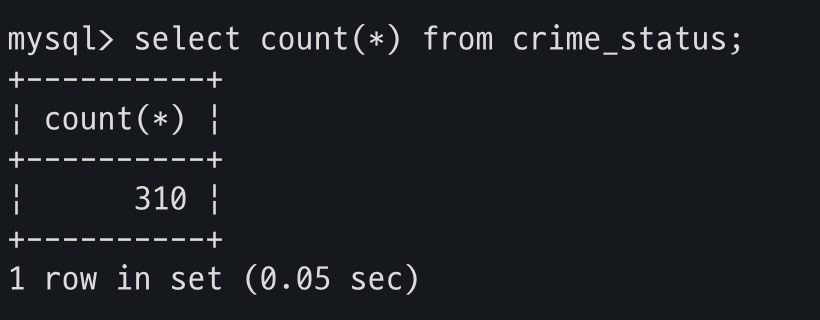

In [54]:
len(cs_df)

310

In [55]:
cs_df = pd.DataFrame(result)
cs_df.head()

,0,1,2,3,4
0,2020,중부,살인,발생,1
1,2020,중부,살인,검거,1
2,2020,중부,강도,발생,3
3,2020,중부,강도,검거,4
4,2020,중부,"강간,추행",발생,113


In [56]:
remote.close()

### cctv 테이블에 cctv.csv 데이터를 입력

In [62]:
cctv_df = pd.read_csv("Seoul_CCTV.csv")
cctv_df.head()

,기관명,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,3238,1292,430,584,932
1,강동구,1010,379,99,155,377
2,강북구,831,369,120,138,204
3,강서구,911,388,258,184,81
4,관악구,2109,846,260,390,613


In [57]:
remote = mysql.connector.connect(
    host = aws_host, 
    user = aws_user,
    password = aws_password,
    port = aws_port,
    database="zerobase"
)

In [58]:
# cursor 생성
cur = remote.cursor(buffered=True)

In [68]:
# cctv Table 생성
sql = "CREATE TABLE cctv (기관명 varchar(8), 소계 int, `2013년도 이전` int, 2014년 int, 2015년 int, 2016년 int)"
cur.execute(sql)

In [72]:
# 데이터를 cctv 테이블에 INSERT
sql = "INSERT INTO cctv VALUES(%s, %s, %s, %s, %s, %s)"

for idx, row in cctv_df.iterrows():
    cur.execute(sql, tuple(row))
    remote.commit()

In [74]:
# cctv 테이블 데이터 조회
cur.execute("SELECT * FROM cctv")

result = cur.fetchall()

print(len(result), len(cctv_df))
for result_iterator in result:
    print(result_iterator)

25 25
('강남구', 3238, 1292, 430, 584, 932)
('강동구', 1010, 379, 99, 155, 377)
('강북구', 831, 369, 120, 138, 204)
('강서구', 911, 388, 258, 184, 81)
('관악구', 2109, 846, 260, 390, 613)
('광진구', 878, 573, 78, 53, 174)
('구로구', 1884, 1142, 173, 246, 323)
('금천구', 1348, 674, 51, 269, 354)
('노원구', 1566, 542, 57, 451, 516)
('도봉구', 825, 238, 159, 42, 386)
('동대문구', 1870, 1070, 23, 198, 579)
('동작구', 1302, 544, 341, 103, 314)
('마포구', 980, 314, 118, 169, 379)
('서대문구', 1254, 844, 50, 68, 292)
('서초구', 2297, 1406, 157, 336, 398)
('성동구', 1327, 730, 91, 241, 265)
('성북구', 1651, 1009, 78, 360, 204)
('송파구', 1081, 529, 21, 68, 463)
('양천구', 2482, 1843, 142, 30, 467)
('영등포구', 1277, 495, 214, 195, 373)
('용산구', 2096, 1368, 218, 112, 398)
('은평구', 2108, 1138, 224, 278, 468)
('종로구', 1619, 464, 314, 211, 630)
('중구', 1023, 413, 190, 72, 348)
('중랑구', 916, 509, 121, 177, 109)


In [76]:
cctv_df = pd.DataFrame(result)
cctv_df.head()

,0,1,2,3,4,5
0,강남구,3238,1292,430,584,932
1,강동구,1010,379,99,155,377
2,강북구,831,369,120,138,204
3,강서구,911,388,258,184,81
4,관악구,2109,846,260,390,613


In [77]:
remote.close()